# Twitter Sentiment Anaylsis with 1.6 Million Dataset

In [35]:
#DataFrame
import pandas as pd

#MatPlot
import matplotlib.pyplot as plt
%matplotlib inline

#Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

#Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPool1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

#NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

#Word2Vec
import gensim

#Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

#Set log
logging.basicConfig(format='%(asctime)s : $(levelname)s : %(message)s', level=logging.INFO)


In [36]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\NAUFAL
[nltk_data]     HAFIZH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Variable Settings

In [37]:
# DATASET
DATASET_COLUMNS=["target","ids","date","flag","user","text"]
DATASET_ENCODING="ISO-8859-1"
TRAIN_SIZE=0.8

# TEXT CLEANING
TEXT_CLEANING_RE="@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
W2V_SIZE=300
W2V_WINDOW=7
W2V_EPOCH=32
W2V_MIN_COUNT=10

# KERAS
SEQUENCE_LENGTH=300
EPOCHS=8
BATCH_SIZE=1024

#SENTIMENT
POSITIVE="POSITIVE"
NEGATIVE="NEGATIVE"
NEUTRAL="NEUTRAL"
SENTIMENT_THRESHOLD=(0.4,0.7)

#EXPORT
KERAS_MODEL="model.h5"
WORD2VEC_MODEL="model.w2v"
TOKENIZER_MODEL="tokenizer.pkl"
ENCODER_MODEL="encoder.pkl"

### Read Dataset

In [40]:
df=pd.read_csv('training.1600000.processed.noemoticon.csv',encoding=DATASET_ENCODING,names=DATASET_COLUMNS)

In [41]:
print('Dataset Size : ',len(df))

Dataset Size :  1600000


In [42]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [43]:
decode_map={0:"NEGATIVE",2:"NEUTRAL",4:"POSITIVE"}
def decode_sentiment(label):
  return decode_map[int(label)]

In [44]:
%%time
df.target=df.target.apply(lambda x:decode_sentiment(x))

CPU times: total: 547 ms
Wall time: 605 ms


Text(0.5, 1.0, 'Dataset Table Distribution')

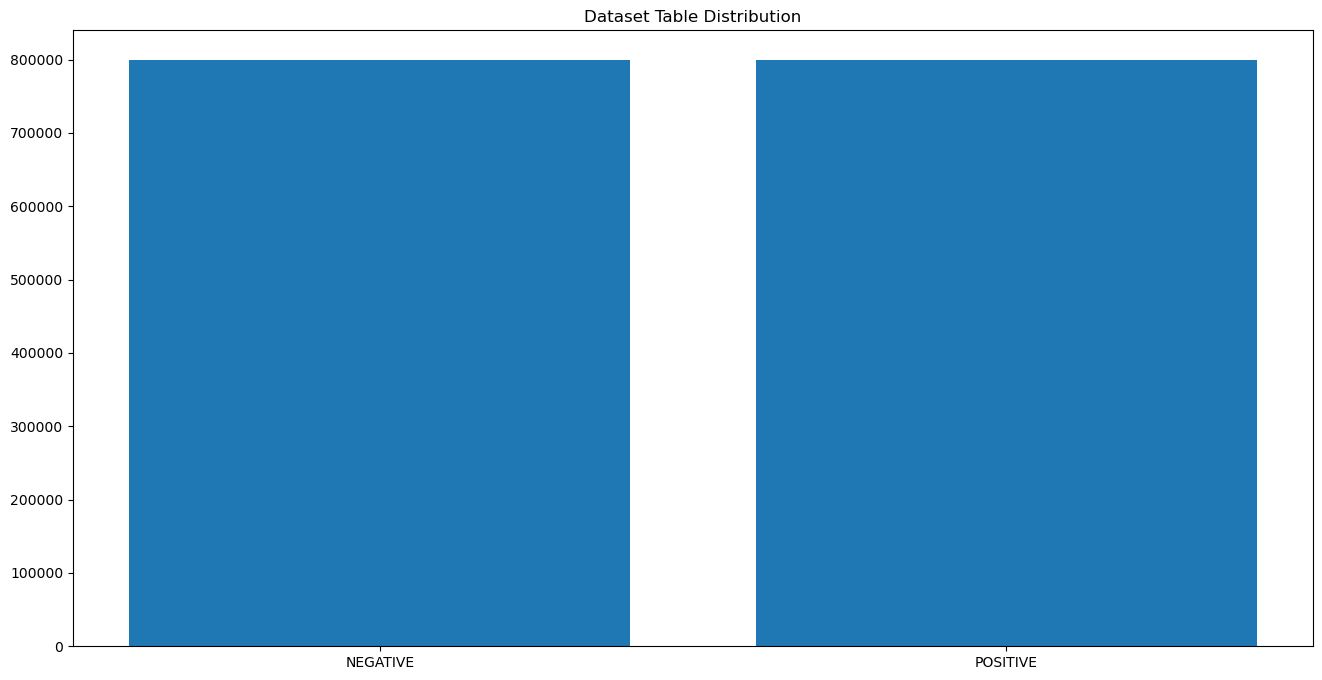

In [45]:
target_cnt=Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(),target_cnt.values())
plt.title("Dataset Table Distribution")

### Pre-Process Dataset

In [46]:
stop_words=stopwords.words('english')
stemmer=SnowballStemmer('english')

In [47]:
def preprocess(text,stem=False):
  # Remove link, user, and special characters
  text=re.sub(TEXT_CLEANING_RE,' ',str(text).lower()).strip()
  tokens=[]

  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [49]:
%%time
df.text=df.text.apply(lambda x: preprocess(x))

CPU times: total: 59.2 s
Wall time: 1min 1s


### Split Train and Test

In [50]:
df_train,df_test=train_test_split(df,test_size=1-TRAIN_SIZE,random_state=42)
print('TRAIN Size : ',len(df_train))
print('TEST Size ; ',len(df_test))

TRAIN Size :  1280000
TEST Size ;  320000


### Word2Vec

In [52]:
%%time
documents=[_text.split() for _text in df_train.text]

CPU times: total: 3.41 s
Wall time: 3.75 s


In [56]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

2022-11-27 14:52:58,415 : $(levelname)s : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2022-11-27T14:52:58.415071', 'gensim': '4.2.0', 'python': '3.9.15 (main, Nov 23 2022, 09:27:34) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}


In [57]:
w2v_model.build_vocab(documents)

2022-11-27 14:55:32,947 : $(levelname)s : collecting all words and their counts
2022-11-27 14:55:32,948 : $(levelname)s : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-27 14:55:32,972 : $(levelname)s : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2022-11-27 14:55:32,999 : $(levelname)s : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2022-11-27 14:55:33,033 : $(levelname)s : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2022-11-27 14:55:33,075 : $(levelname)s : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2022-11-27 14:55:33,113 : $(levelname)s : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2022-11-27 14:55:33,141 : $(levelname)s : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2022-11-27 14:55:33,168 : $(levelname)s : PROGRESS: at sentence #70000, processed 50310

In [59]:
words=w2v_model.wv.key_to_index.keys()
vocab_size=len(words)
print("Vocab Size : ",vocab_size)

Vocab Size :  30369


In [60]:
%%time
w2v_model.train(documents,total_examples=len(documents),epochs=W2V_EPOCH)

2022-11-27 15:00:22,311 : $(levelname)s : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2022-11-27T15:00:22.311322', 'gensim': '4.2.0', 'python': '3.9.15 (main, Nov 23 2022, 09:27:34) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'train'}
2022-11-27 15:00:23,389 : $(levelname)s : EPOCH 0 - PROGRESS: at 7.71% examples, 621231 words/s, in_qsize 16, out_qsize 0
2022-11-27 15:00:24,392 : $(levelname)s : EPOCH 0 - PROGRESS: at 16.05% examples, 652427 words/s, in_qsize 15, out_qsize 0
2022-11-27 15:00:25,401 : $(levelname)s : EPOCH 0 - PROGRESS: at 21.79% examples, 590892 words/s, in_qsize 15, out_qsize 0
2022-11-27 15:00:26,420 : $(levelname)s : EPOCH 0 - PROGRESS: at 29.16% examples, 591766 words/s, in_qsize 16, out_qsize 2
2022-11-27 15:00:27,460 : $(levelname)s : EPOCH 0 - PROGRESS: at 37.27% examples, 602111 words/s

CPU times: total: 18min 10s
Wall time: 5min 58s


(263120043, 295270528)

In [61]:
w2v_model.wv.most_similar('love')

[('luv', 0.5617384910583496),
 ('loves', 0.553658127784729),
 ('loved', 0.5402815341949463),
 ('amazing', 0.5181358456611633),
 ('adore', 0.4984983205795288),
 ('looove', 0.4813774824142456),
 ('awesome', 0.4759594798088074),
 ('loooove', 0.45128104090690613),
 ('loveee', 0.4496622085571289),
 ('lovee', 0.44613930583000183)]

### Tokenize Text

In [62]:
%%time
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size=len(tokenizer.word_index)+1
print('Total Words : ',vocab_size)

Total Words :  290419
CPU times: total: 22.5 s
Wall time: 24 s


In [63]:
%%time
x_train=pad_sequences(tokenizer.texts_to_sequences(df_train.text),maxlen=SEQUENCE_LENGTH)
x_test=pad_sequences(tokenizer.texts_to_sequences(df_test),maxlen=SEQUENCE_LENGTH)

CPU times: total: 25.9 s
Wall time: 27.5 s


### Label Encoder

In [64]:
labels=df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [66]:
encoder=LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train=encoder.transform(df_train.target.tolist())
y_test=encoder.transform(df_test.target.tolist())

y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

print('y_train ',y_train.shape)
print('y_test ',y_test.shape)

y_train  (1280000, 1)
y_test  (320000, 1)


In [67]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (6, 300)
y_test (320000, 1)


In [68]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding Layer

In [69]:
embedding_matrix=np.zeros((vocab_size,W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i]=w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [70]:
embedding_layer=Embedding(vocab_size,W2V_SIZE,weights=[embedding_matrix],input_length=SEQUENCE_LENGTH,trainable=False)

### Build Model

In [71]:
model=Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile Model

In [72]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [73]:
callbacks=[ReduceLROnPlateau(monitor='val_loss',patience=5,cooldown=0),EarlyStopping(monitor='val_acc',min_delta=1e-4,patience=5)]

### Model Train

In [74]:
%%time
history=model.fit(x_train,y_train,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_split=0.1,
                  verbose=1,
                  callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.7506 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-11-27 19:48:04,373 : $(levelname)s : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 14479s 13s/step - loss: 0.5042 - accuracy: 0.7506 - val_loss: 0.4676 - val_accuracy: 0.7769 - lr: 0.0010
Epoch 2/8
 891/1125 [======================>.......] - ETA: 52:09 - loss: 0.4795 - accuracy: 0.7673